<center>
    <h1 style = "font-size:24px; font-weight:normal">Uczenie maszynowe</h1>
    <h1 style = "font-size:24px">DermaMNIST</h1>
    <h1 style = "font-size:24px">Paweł Tumialis 180529</h1>
    <h1 style = "font-size:24px">Sztuczna inteligencja</h1>
        <h1 style = "font-size:24px">09.06.2023</h1>
</center>

# Pobranie bazy danych

In [1]:
import keras
import tensorflow as tf
import numpy as np
from medmnist import DermaMNIST
import matplotlib.pyplot as plt 
import random

In [67]:
train_dataset = DermaMNIST(split='train', download=True)
test_dataset = DermaMNIST(split='test', download=True)
valid_dataset = DermaMNIST(split='val', download=True)

Using downloaded and verified file: C:\Users\pawel\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\pawel\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\pawel\.medmnist\dermamnist.npz


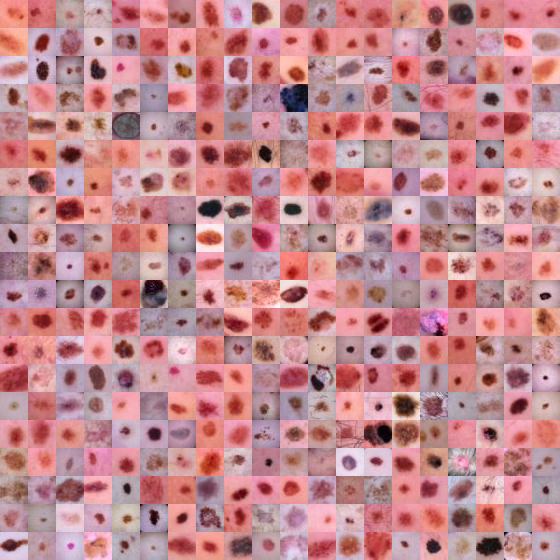

In [68]:
test_dataset.montage(length=20)

In [69]:
vars(train_dataset)

{'info': {'python_class': 'DermaMNIST',
  'description': 'The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.',
  'url': 'https://zenodo.org/record/6496656/files/dermamnist.npz?download=1',
  'MD5': '0744692d530f8e62ec473284d019b0c7',
  'task': 'multi-class',
  'label': {'0': 'actinic keratoses and intraepithelial carcinoma',
   '1': 'basal cell carcinoma',
   '2': 'benign keratosis-like lesions',
   '3': 'dermatofibroma',
   '4': 'melanoma',
   '5': 'melanocytic nevi',
   '6': 'vascular lesions'},
  'n_channels': 3,
  'n_samples': {'train': 7007, 'val': 1003, 'test': 2005},
  'license': 'CC BY 4.0'},
 'root': 'C:\\Users\\pawel\\.medmni

In [70]:
train = train_dataset.imgs
train_labels = train_dataset.labels
test = test_dataset.imgs
test_labels = test_dataset.labels
valid = valid_dataset.imgs
valid_labels = valid_dataset.labels
print(train[0].shape, type(valid), type(valid_labels))

(28, 28, 3) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


# Przetwarzanie wstępne

In [71]:
from sklearn.preprocessing import OneHotEncoder
# zmiana na skalę szarości
'''
train_grey = np.ndarray(shape=(len(train), 28, 28))
test_grey = np.ndarray(shape=(len(test), 28, 28))
valid_grey = np.ndarray(shape=(len(valid), 28, 28))

train_grey_re = np.ndarray(shape=(len(train), 28*28))
test_grey_re = np.ndarray(shape=(len(test), 28*28))
valid_grey_re = np.ndarray(shape=(len(valid), 28*28))
for i in range(len(train)):
    train_grey[i] = np.dot(train[i], [0.2989, 0.5870, 0.1140])
    train_grey_re[i] = train_grey[i].reshape((28*28))
for i in range(len(test)):
    test_grey[i] = np.dot(test[i], [0.2989, 0.5870, 0.1140])
    test_grey_re[i] = test_grey[i].reshape((28*28))
for i in range(len(valid)):
    valid_grey[i] = np.dot(valid[i], [0.2989, 0.5870, 0.1140])
    valid_grey_re[i] = valid_grey[i].reshape((28*28))
plt.imshow(train_grey[1])
'''
train_grey_re = np.ndarray(shape=(len(train), 28*28*3))
test_grey_re = np.ndarray(shape=(len(test), 28*28*3))
valid_grey_re = np.ndarray(shape=(len(valid), 28*28*3))
for i in range(len(train)):
    train_grey_re[i] = train[i].reshape((28*28*3))
for i in range(len(test)):
    test_grey_re[i] = test[i].reshape((28*28*3))
for i in range(len(valid)):
    valid_grey_re[i] = valid[i].reshape((28*28*3))
    
print(train_labels[1])
test_labels_f1 = test_labels
enc = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype='float32')
train_labels = enc.fit_transform(train_labels)
test_labels = enc.transform(test_labels)
valid_labels = enc.transform(valid_labels)
print(train_labels[1])

[5]
[0. 0. 0. 0. 0. 1. 0.]


C:\Users\pawel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Proste DNN

In [56]:
# to jest mały model i ma tendencję do wpadania w minima, jeśli sieć się nie uczy najlepiej zresetować uczenie
import tensorflow as tf
# opcje ------------
SHUFFLE_BUFFER_SIZE = 100
BATCH = 32
LR = 1e-5
LAYERS = 3
NEURONS = 48
EPOCHS = 250
# ---------------------
train_dataset = tf.data.Dataset.from_tensor_slices((train_grey_re, train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_grey_re, valid_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_grey_re, test_labels))

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH)
valid_dataset = valid_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH)
test_dataset = test_dataset.batch(BATCH)

seed=random.seed()
np.random.seed(seed)
tf.compat.v1.random.set_random_seed(seed)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.9, beta_2=0.999)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(28*28*3,)))
for i in range(LAYERS):
    model.add(tf.keras.layers.Dense(units=NEURONS, activation='relu',use_bias=False))
model.add(tf.keras.layers.Dense(7, activation='relu',use_bias=False))
model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 48)                112896    
                                                                 
 dense_13 (Dense)            (None, 48)                2304      
                                                                 
 dense_14 (Dense)            (None, 48)                2304      
                                                                 
 dense_15 (Dense)            (None, 7)                 336       
                                                                 
Total params: 117,840
Trainable params: 117,840
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)
model_train = model.fit(train_dataset, validation_data=valid_dataset, epochs=EPOCHS, callbacks=[model_checkpoint_callback])
model.load_weights(checkpoint_filepath)
model_evaluation = model.evaluate(test_dataset)

best_valid_accu = max(model_train.history['val_categorical_accuracy'])
best_epoch = model_train.history['val_categorical_accuracy'].index(best_valid_accu)
best_train_accu = model_train.history['categorical_accuracy'][best_epoch]
accuracy = model_evaluation[1]


Epoch 1/200
219/219 [==============================] - 1s 4ms/step - loss: 8.3351 - categorical_accuracy: 0.4067 - val_loss: 1.8143 - val_categorical_accuracy: 0.3220
Epoch 2/200
219/219 [==============================] - 1s 3ms/step - loss: 1.7461 - categorical_accuracy: 0.3310 - val_loss: 1.6803 - val_categorical_accuracy: 0.2622
Epoch 3/200
219/219 [==============================] - 1s 3ms/step - loss: 1.5473 - categorical_accuracy: 0.3793 - val_loss: 1.5404 - val_categorical_accuracy: 0.3430
Epoch 4/200
219/219 [==============================] - 1s 4ms/step - loss: 1.4852 - categorical_accuracy: 0.3936 - val_loss: 1.4896 - val_categorical_accuracy: 0.3918
Epoch 5/200
219/219 [==============================] - 1s 3ms/step - loss: 1.4561 - categorical_accuracy: 0.4089 - val_loss: 1.4654 - val_categorical_accuracy: 0.3719
Epoch 6/200
219/219 [==============================] - 1s 3ms/step - loss: 1.4233 - categorical_accuracy: 0.4266 - val_loss: 1.4345 - val_categorical_accuracy: 0.430

Epoch 50/200
219/219 [==============================] - 1s 3ms/step - loss: 1.1338 - categorical_accuracy: 0.6214 - val_loss: 1.1675 - val_categorical_accuracy: 0.6221
Epoch 51/200
219/219 [==============================] - 1s 3ms/step - loss: 1.1375 - categorical_accuracy: 0.6215 - val_loss: 1.1568 - val_categorical_accuracy: 0.6361
Epoch 52/200
219/219 [==============================] - 1s 3ms/step - loss: 1.1345 - categorical_accuracy: 0.6195 - val_loss: 1.1682 - val_categorical_accuracy: 0.6391
Epoch 53/200
219/219 [==============================] - 1s 3ms/step - loss: 1.1406 - categorical_accuracy: 0.6165 - val_loss: 1.1662 - val_categorical_accuracy: 0.6431
Epoch 54/200
219/219 [==============================] - 1s 3ms/step - loss: 1.1170 - categorical_accuracy: 0.6274 - val_loss: 1.1679 - val_categorical_accuracy: 0.6152
Epoch 55/200
219/219 [==============================] - 1s 3ms/step - loss: 1.1256 - categorical_accuracy: 0.6241 - val_loss: 1.1485 - val_categorical_accuracy:

Epoch 99/200
219/219 [==============================] - 1s 3ms/step - loss: 1.0591 - categorical_accuracy: 0.6438 - val_loss: 1.1561 - val_categorical_accuracy: 0.6082
Epoch 100/200
219/219 [==============================] - 1s 3ms/step - loss: 1.0585 - categorical_accuracy: 0.6432 - val_loss: 1.1132 - val_categorical_accuracy: 0.6321
Epoch 101/200
219/219 [==============================] - 1s 3ms/step - loss: 1.0607 - categorical_accuracy: 0.6431 - val_loss: 1.1128 - val_categorical_accuracy: 0.6640
Epoch 102/200
219/219 [==============================] - 1s 3ms/step - loss: 1.0652 - categorical_accuracy: 0.6408 - val_loss: 1.1135 - val_categorical_accuracy: 0.6680
Epoch 103/200
219/219 [==============================] - 1s 3ms/step - loss: 1.0559 - categorical_accuracy: 0.6456 - val_loss: 1.1121 - val_categorical_accuracy: 0.6540
Epoch 104/200
219/219 [==============================] - 1s 3ms/step - loss: 1.0622 - categorical_accuracy: 0.6441 - val_loss: 1.1120 - val_categorical_accu

219/219 [==============================] - 1s 3ms/step - loss: 1.0295 - categorical_accuracy: 0.6475 - val_loss: 1.1051 - val_categorical_accuracy: 0.6670
Epoch 148/200
219/219 [==============================] - 1s 3ms/step - loss: 1.0256 - categorical_accuracy: 0.6523 - val_loss: 1.1041 - val_categorical_accuracy: 0.6630
Epoch 149/200
219/219 [==============================] - 1s 3ms/step - loss: 1.0396 - categorical_accuracy: 0.6451 - val_loss: 1.1038 - val_categorical_accuracy: 0.6710
Epoch 150/200
219/219 [==============================] - 1s 3ms/step - loss: 1.0252 - categorical_accuracy: 0.6494 - val_loss: 1.1045 - val_categorical_accuracy: 0.6680
Epoch 151/200
219/219 [==============================] - 1s 3ms/step - loss: 1.0237 - categorical_accuracy: 0.6502 - val_loss: 1.1192 - val_categorical_accuracy: 0.6730
Epoch 152/200
219/219 [==============================] - 1s 3ms/step - loss: 1.0320 - categorical_accuracy: 0.6502 - val_loss: 1.1289 - val_categorical_accuracy: 0.6740


219/219 [==============================] - 1s 3ms/step - loss: 1.0152 - categorical_accuracy: 0.6539 - val_loss: 1.1052 - val_categorical_accuracy: 0.6690
Epoch 196/200
219/219 [==============================] - 1s 3ms/step - loss: 0.9980 - categorical_accuracy: 0.6559 - val_loss: 1.0950 - val_categorical_accuracy: 0.6680
Epoch 197/200
219/219 [==============================] - 1s 3ms/step - loss: 1.0045 - categorical_accuracy: 0.6555 - val_loss: 1.1153 - val_categorical_accuracy: 0.6730
Epoch 198/200
219/219 [==============================] - 1s 4ms/step - loss: 1.0027 - categorical_accuracy: 0.6555 - val_loss: 1.0982 - val_categorical_accuracy: 0.6690
Epoch 199/200
219/219 [==============================] - 1s 3ms/step - loss: 1.0040 - categorical_accuracy: 0.6559 - val_loss: 1.1070 - val_categorical_accuracy: 0.6750
Epoch 200/200
63/63 [==============================] - 0s 1ms/step - loss: 1.1662 - categorical_accuracy: 0.6603
Dokładność modelu 0.6603491306304932


In [72]:
print('Dokładność modelu {}'.format(accuracy))
from sklearn.metrics import f1_score
images, labels = tuple(zip(*test_dataset))
y_pred1 = model.predict(test_grey_re)
y_pred = np.argmax(y_pred1, axis=1)
y_pred = y_pred.reshape(len(test_labels_f1), 1)
print('F1 score modelu = {}'.format(f1_score(test_labels_f1, y_pred , average="macro")))

Dokładność modelu 0.6603491306304932
63/63 [==============================] - 0s 1ms/step
F1 score modelu = 0.14488353937826678
